In [208]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
genSavePath = f"{os.getcwd()}/SavedResults/"
day = "18" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 34
repetitionName =  "normalTest3"#  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = True
if saveTop:
    saveTopName = "top2udrli.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)


85
9.444444444444445


In [209]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    # print(currSubj)
    # if currSubj == 1:
    #     currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:
                
                aName = aResults2[0]
                ares = aResults2[1]
                akernel = aResults2[2]
 
                aC = aResults2[3]
               
                combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
               
# combinationResult[1:,:,1] = combinationResult[1:,:,1] / combinationAmounts[1,:]
for subNr, subj in enumerate(combinationResult[1:], 1):
    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    if "adaBoost" in kernels or "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

combinationResult[combinationResult > 1.001] = combinationResult[combinationResult > 1.001] / 2
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])

lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
    
            cmbNr = int(res[0])

            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]

            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




/tmp/ipykernel_6922/1786930322.py:159: RuntimeWarning: invalid value encountered in true_divide
  comboAverage = comboAverage / nrOfSubjects


,0,3,4,5,6,7,8,9,12,13,14,15,16,17,18,21,22,23,24,25,26,27,30,31,32,33,34,35,36,39,40,41,42,43,44,54,57,58,59,60,61,62,63,66,67,68,69,70,71,72,75,76,77,78,79,80,90,93,94,95,96,97,98,99,102,103,104,105,106,107,117,120,121,122,123,124,125,126,129,130,131,132,133,134,135,138,139,140,141,142,143,144,147,148,149,150,151,152,162,165,166,167,168,169,170,171,174,175,176,177,178,179,189,192,193,194,195,196,197,198,201,202,203,204,205,206,207,210,211,212,213,214,215,216,219,220,221,222,223,224,225,228,229,230,231,232,233,243,246,247,248,249,250,251,252,255,256,257,258,259,260,270,273,274,275,276,277,278,279,282,283,284,285,286,287,288,291,292,293,294,295,296,297,300,301,302,303,304,305,306,309,310,311,312,313,314,324,327,328,329,330,331,332,342,345,346,347,348,349,350,351,354,355,356,357,358,359,360,363,364,365,366,367,368,369,372,373,374,375,376,377,378,381,382,383,384,385,386,396,399,400,401,402,403,404,414,417,418,419,420,421,422,423,426,427,428,429,430,431,432,435,436,437,438,439,440,441,444,445,446,447,448,449,450,453,454,455,456,457,458,468,471,472,473,474,475,476,477,480,481,482,483,484,485,495,498,499,500,501,502,503,504,507,508,509,510,511,512,513,516,517,518,519,520,521,531,534,535,536,537,538,539,549,552,553,554,555,556,557,558,561,562,563,564,565,566,567,570,571,572,573,574,575,576,579,580,581,582,583,584,585,588,589,590,591,592,593,603,606,607,608,609,610,611,612,615,616,617,618,619,620,630,633,634,635,636,637,638,639,642,643,644,645,646,647,648,651,652,653,654,655,656,657,660,661,662,663,664,665,666,669,670,671,672,673,674,684,687,688,689,690,691,692,693,696,697,698,699,700,701,711,714,715,716,717,718,719,720,723,724,725,726,727,728,729,732,733,734,735,736,737,738,741,742,743,744,745,746,747,750,751,752,753,754,755,765,768,769,770,771,772,773,774,777,778,779,780,781,782,792,795,796,797,798,799,800,801,804,805,806,807,808,809,810,813,814,815,816,817,818,819,822,823,824,825,826,827,828,831,832,833,834,835,836,846,849,850,851,852,853,854,855,858,859,860,861,862,863,873,876,877,878,879,880,881,882,885,886,887,888,889,890,891,894,895,896,897,898,899,900,903,904,905,906,907,908,909,912,913,914,915,916,917,927,930,931,932,933,934,935,936,939,940,941,942,943,944,954,957,958,959,960,961,962,963,966,967,968,969,970,971,972,975,976,977,978,979,980,981,984,985,986,987,988,989,990,993,994,995,996,997,998,1008,1011,1012,1013,1014,1015,1016,1026,1029,1030,1031,1032,1033,1034,1035,1038,1039,1040,1041,1042,1043,1044,1047,1048,1049,1050,1051,1052,1053,1056,1057,1058,1059,1060,1061,1062,1065,1066,1067,1068,1069,1070,1080,1083,1084,1085,1086,1087,1088,1089,1092,1093,1094,1095,1096,1097,1107,1110,1111,1112,1113,1114,1115,1116,1119,1120,1121,1122,1123,1124,1125,1128,1129,1130,1131,1132,1133,1134,1137,1138,1139,1140,1141,1142,1143,1146,1147,1148,1149,1150,1151,1161,1164,1165,1166,1167,1168,1169,1170,1173,1174,1175,1176,1177,1178,1179,1182,1183,1184,1185,1186,1187,1188,1191,1192,1193,1194,1195,1196,1197,1200,1201,1202,1203,1204,1205,1206,1209,1210,1211,1212,1213,1214
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,N

In [210]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,fftData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC,fftData_BC_&_gausData_BC_CV_&_welchData_CV_BC,fftData_BC_&_welchData_BC_&_gausData_BC,welchData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC,welchData_BC_&_gausData_BC_CV_&_welchData_CV_BC,welchData_BC_&_fftData_BC_&_stftData_CV_BC,welchData_BC_&_fftData_BC_&_stftData_CV_BC,welchData_BC_&_fftData_BC_&_gausData_BC,welchData_BC_&_fftData_BC_&_hilbertData_BC,hilbertData_BC_&_fftData_BC_&_welchData_BC,hilbertData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC,hilbertData_BC_&_gausData_BC_CV_&_welchData_CV_BC,hilbertData_BC_&_fftData_BC_&_stftData_CV_BC,hilbertData_BC_&_fftData_BC_&_stftData_CV_BC,hilbertData_BC_&_fftData_BC_&_gausData_BC,hilbertData_BC_&_fftData_BC_&_welchData_BC,hilbertData_BC_&_welchData_BC_&_gausData_BC,fftData_BC_CV_&_fftData_BC_&_welchData_BC,fftData_BC_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,fftData_BC_CV_&_gausData_BC_CV_&_welchData_CV_BC,fftData_BC_CV_&_fftData_BC_&_stftData_CV_BC,fftData_BC_CV_&_fftData_BC_&_stftData_CV_BC,fftData_BC_CV_&_fftData_BC_&_gausData_BC,fftData_BC_CV_&_fftData_BC_&_welchData_BC,fftData_BC_CV_&_fftData_BC_&_hilbertData_BC,fftData_BC_CV_&_welchData_BC_&_gausData_BC,welchData_BC_CV_&_fftData_BC_&_welchData_BC,welchData_BC_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,welchData_BC_CV_&_gausData_BC_CV_&_welchData_CV_BC,welchData_BC_CV_&_fftData_BC_&_stftData_CV_BC,welchData_BC_CV_&_fftData_BC_&_stftData_CV_BC,welchData_BC_CV_&_fftData_BC_&_gausData_BC,welchData_BC_CV_&_fftData_BC_&_welchData_BC,welchData_BC_CV_&_fftData_BC_&_hilbertData_BC,welchData_BC_CV_&_welchData_BC_&_gausData_BC,hilbertData_BC_CV_&_fftData_BC_&_welchData_BC,hilbertData_BC_CV_&_gausData_BC_CV_&_welchData_CV_BC,hilbertData_BC_CV_&_fftData_BC_&_stftData_CV_BC,hilbertData_BC_CV_&_fftData_BC_&_stftData_CV_BC,hilbertData_BC_CV_&_fftData_BC_&_gausData_BC,hilbertData_BC_CV_&_fftData_BC_&_welchData_BC,hilbertData_BC_CV_&_fftData_BC_&_hilbertData_BC,hilbertData_BC_CV_&_welchData_BC_&_gausData_BC,gausData_CV_BC_&_fftData_BC_&_welchData_BC,gausData_CV_BC_&_gausData_BC_CV_&_welchData_CV_BC,gausData_CV_BC_&_fftData_BC_&_stftData_CV_BC,gausData_CV_BC_&_fftData_BC_&_stftData_CV_BC,gausData_CV_BC_&_fftData_BC_&_gausData_BC,gausData_CV_BC_&_fftData_BC_&_welchData_BC,gausData_CV_BC_&_fftData_BC_&_hilbertData_BC,gausData_CV_BC_&_welchData_BC_&_gausData_BC,gausData_BC_&_fftData_BC_&_welchData_BC,gausData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC,gausData_BC_&_gausData_BC_CV_&_welchData_CV_BC,gausData_BC_&_fftData_BC_&_stftData_CV_BC,gausData_BC_&_fftData_BC_&_stftData_CV_BC,gausData_BC_&_fftData_BC_&_welchData_BC,gausData_BC_&_fftData_BC_&_hilbertData_BC,gausData_BC_CV_&_fftData_BC_&_welchData_BC,gausData_BC_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,gausData_BC_CV_&_fftData_BC_&_stftData_CV_BC,gausData_BC_CV_&_fftData_BC_&_stftData_CV_BC,gausData_BC_CV_&_fftData_BC_&_gausData_BC,gausData_BC_CV_&_fftData_BC_&_welchData_BC,gausData_BC_CV_&_fftData_BC_&_hilbertData_BC,gausData_BC_CV_&_welchData_BC_&_gausData_BC,fftData_BC_ifft_&_fftData_BC_&_welchData_BC,fftData_BC_ifft_&_hilbertData_BC_CV_&_gausData_CV_BC,fftData_BC_ifft_&_gausData_BC_CV_&_welchData_CV_BC,fftData_BC_ifft_&_fftData_BC_&_stftData_CV_BC,fftData_BC_ifft_&_fftData_BC_&_stftData_CV_BC,fftData_BC_ifft_&_fftData_BC_&_gausData_BC,fftData_BC_ifft_&_fftData_BC_&_welchData_BC,fftData_BC_ifft_&_fftData_BC_&_hilbertData_BC,fftData_BC_ifft_&_welchData_BC_&_gausData_BC,fftData_BC_ifft_CV_&_fftData_BC_&_welchData_BC,fftData_BC_ifft_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,fftData_BC_ifft_CV_&_gausData_BC_CV_&_welchData_CV_BC,fftData_BC_ifft_CV_&_fftData_BC_&_stftData_CV_BC,fftData_BC_ifft_CV_&_fftData_BC_&_stftData_CV_BC,fftData_BC_ifft_CV_&_fftData_BC_&_gausData_BC,fftData_BC_ifft_CV_&_fftData_BC_&_welchData_BC,fftData_BC_ifft_CV_&_fftData_BC_&_hilbertData_BC,fftData_BC_ifft_CV_&_welchData_BC_&_gausData_BC,stftData_BC_&_fftData_BC_&_welchData_BC,stftData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC,stftData_BC_&_gausData_BC_CV_&_welchData_CV_BC,stftData_BC_&_fftD

(135,)




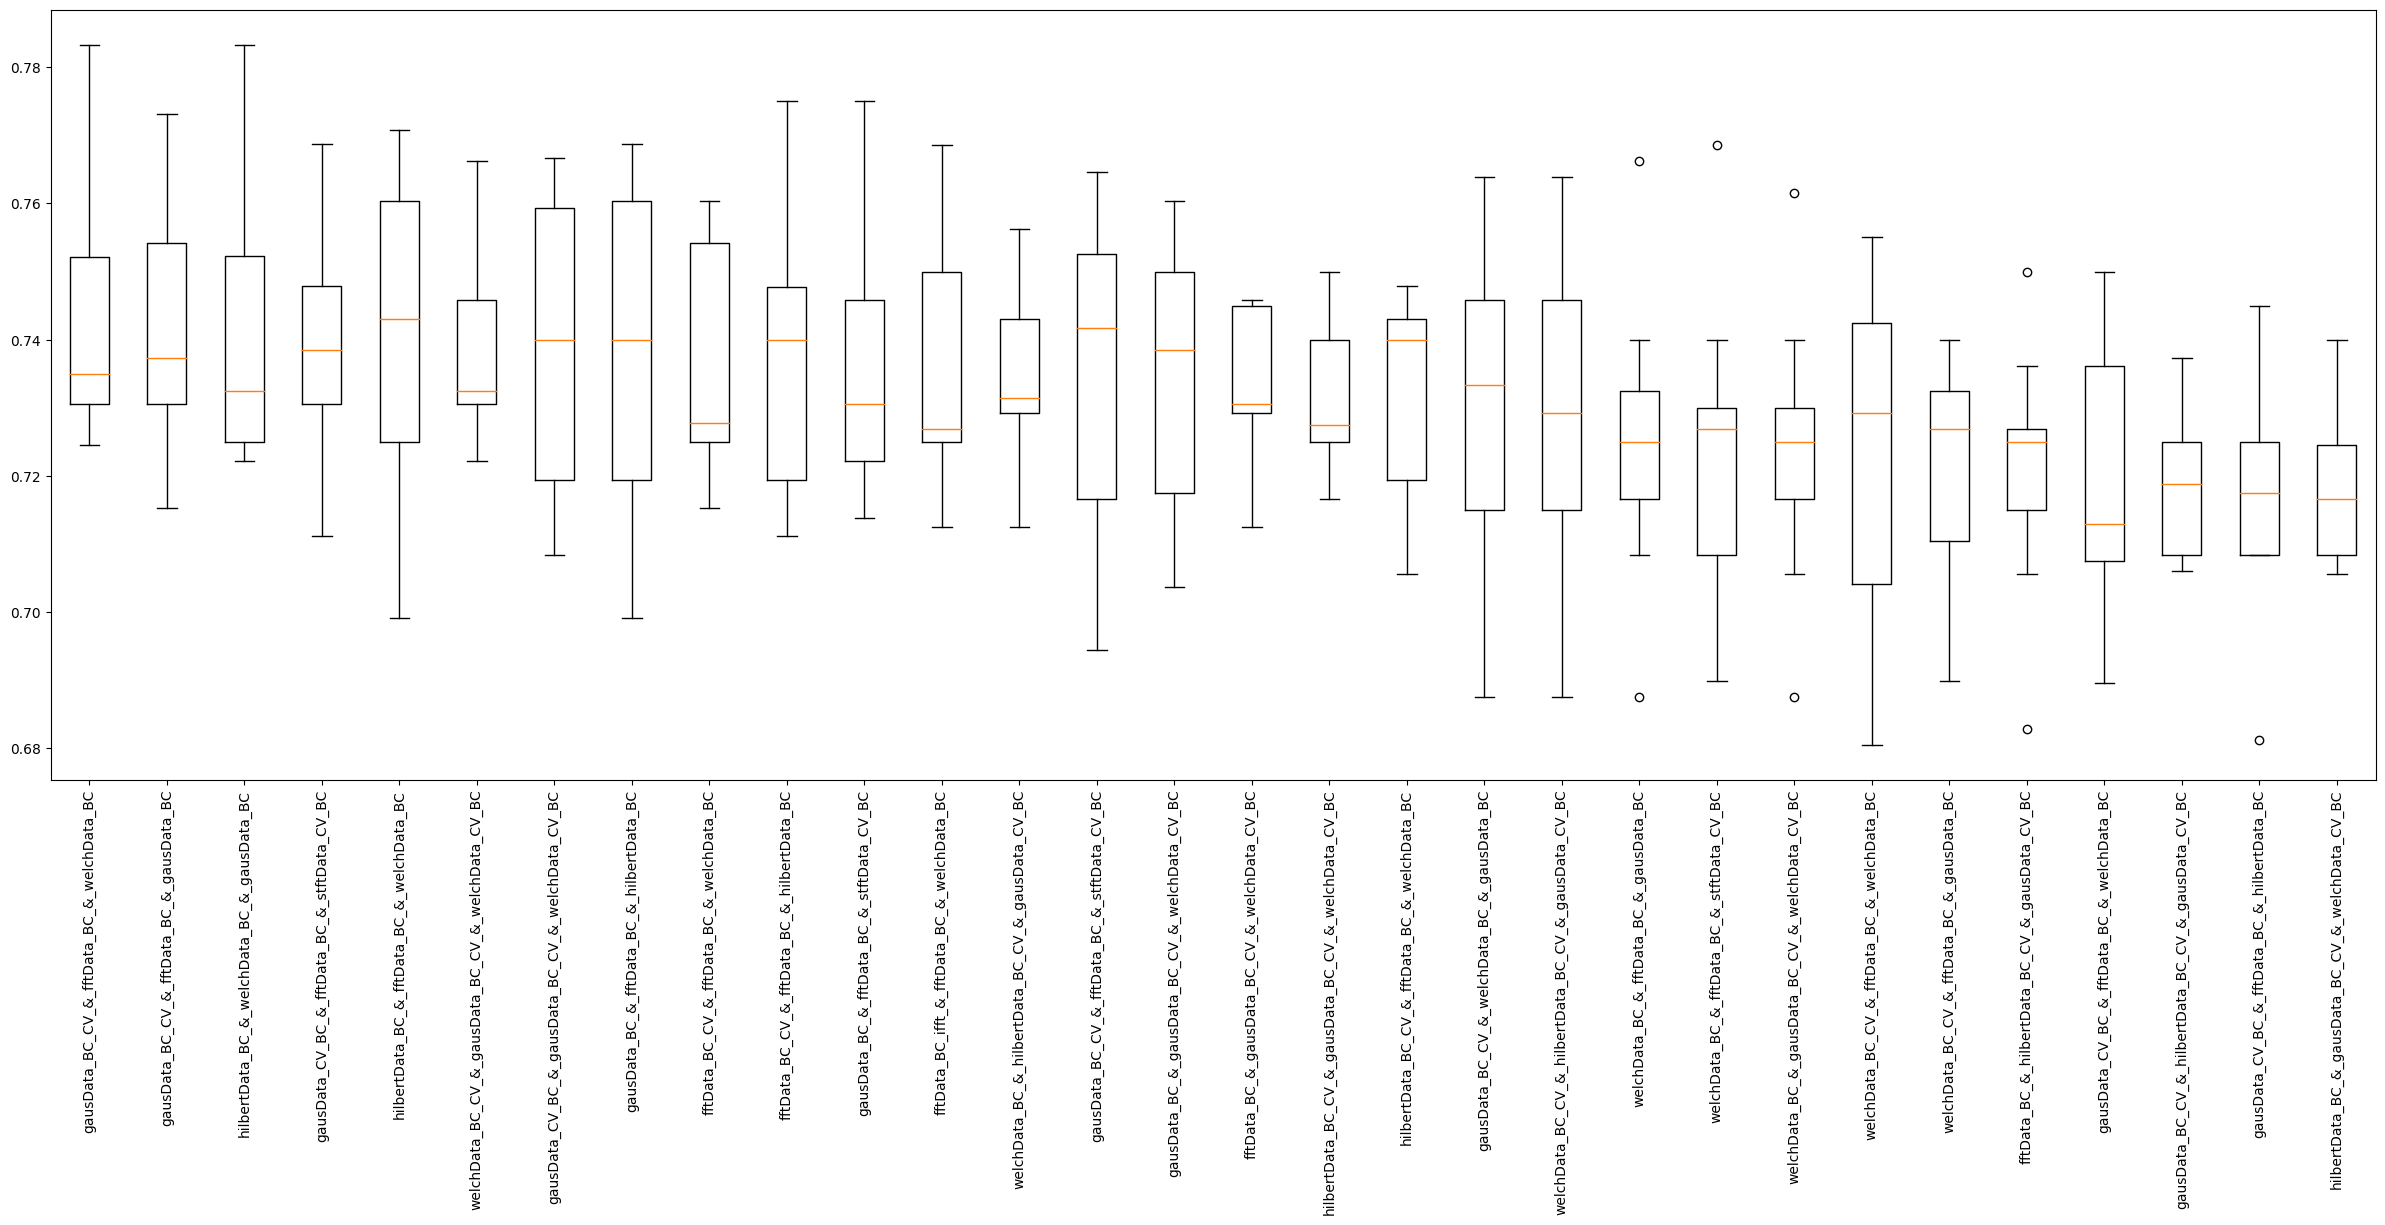

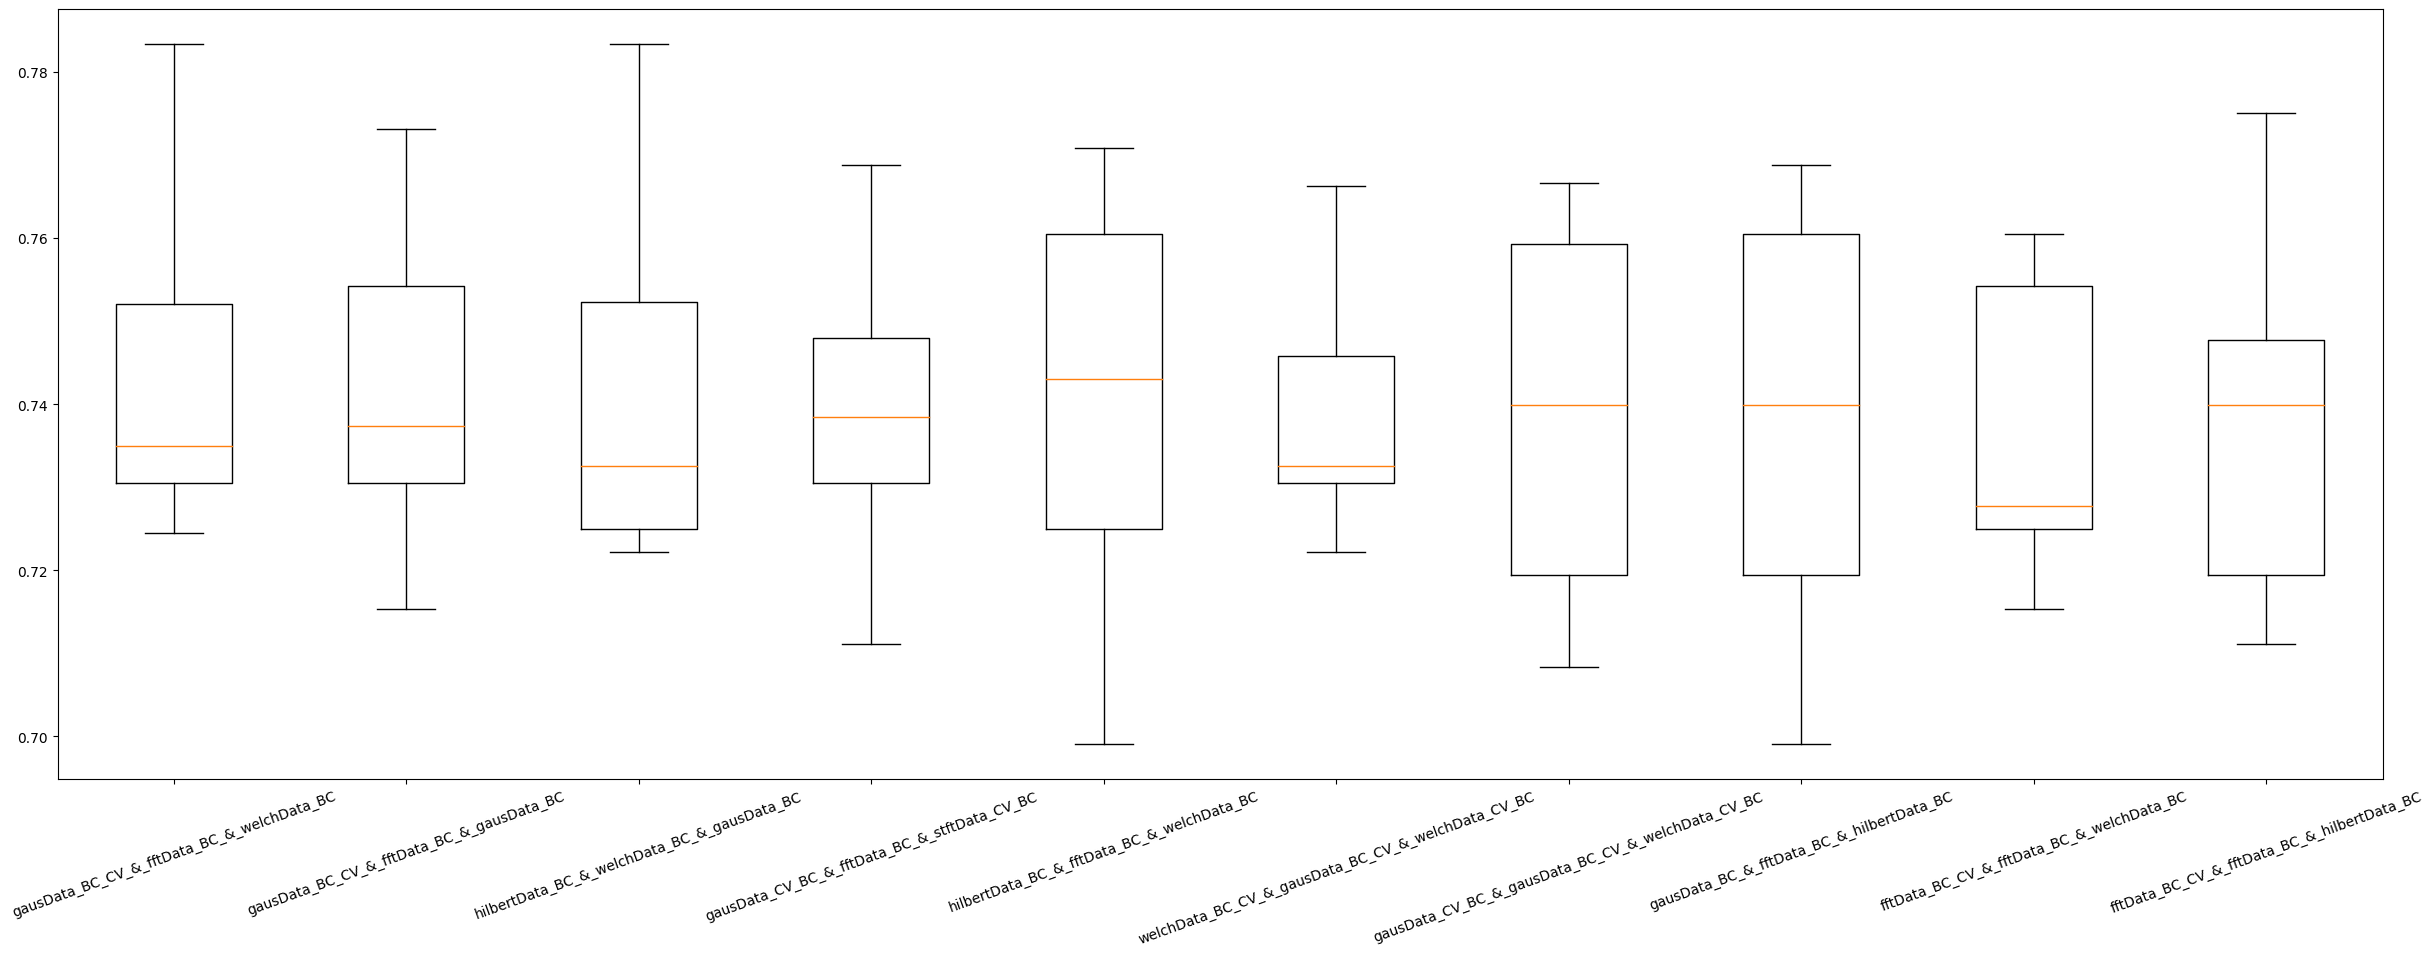

In [211]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [212]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.78 : subject 2, feature:hilbertData_BC_&_welchData_BC_&_gausData_BC, kernellinear, C:10
Accuracy 0.78 : subject 2, feature:hilbertData_BC_&_welchData_BC_&_gausData_BC, kernellinear, C:10
Accuracy 0.78 : subject 2, feature:gausData_BC_CV_&_fftData_BC_&_welchData_BC, kernellinear, C:10
Accuracy 0.78 : subject 2, feature:gausData_BC_CV_&_fftData_BC_&_welchData_BC, kernellinear, C:10
Accuracy 0.78 : subject 2, feature:gausData_BC_CV_&_fftData_BC_&_welchData_BC, kernellinear, C:5
Accuracy 0.78 : subject 2, feature:gausData_BC_&_fftData_BC_&_stftData_CV_BC, kernellinear, C:10
Accuracy 0.78 : subject 2, feature:gausData_BC_&_fftData_BC_&_stftData_CV_BC, kernellinear, C:10
Accuracy 0.77 : subject 2, feature:hilbertData_BC_&_welchData_BC_&_gausData_BC, kernellinear, C:5
Accuracy 0.77 : subject 2, feature:fftData_BC_CV_&_fftData_BC_&_hilbertData_BC, kernelrbf, C:1.2
Accuracy 0.77 : subject 5, feature:gausData_BC_CV_&_fftData_BC_&_gausData_BC, kernelrbf, C:1.

In [213]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [214]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    skip = False  
    
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.78 : subject 2, feature:hilbertData_BC_&_welchData_BC_&_gausData_BC, kernellinear, C:10

Accuracy 0.77 : subject 5, feature:gausData_BC_CV_&_fftData_BC_&_gausData_BC, kernelrbf, C:1.2

Accuracy 0.76 : subject 4, feature:gausData_BC_CV_&_fftData_BC_&_stftData_CV_BC, kernelsigmoid, C:5

Accuracy 0.76 : subject 6, feature:hilbertData_BC_&_fftData_BC_&_stftData_CV_BC, kernelrbf, C:2.5

Accuracy 0.75 : subject 8, feature:gausData_CV_BC_&_fftData_BC_&_welchData_BC, kernelrbf, C:1.2

Accuracy 0.75 : subject 9, feature:gausData_CV_BC_&_gausData_BC_CV_&_welchData_CV_BC, kernelsigmoid, C:0.5

Accuracy 0.74 : subject 1, feature:welchData_BC_CV_&_fftData_BC_&_welchData_BC, kernelrbf, C:0.5

Accuracy 0.74 : subject 7, feature:gausData_CV_BC_&_fftData_BC_&_stftData_CV_BC, kernelrbf, C:0.5

Accuracy 0.73 : subject 3, feature:gausData_BC_CV_&_fftData_BC_&_gausData_BC, kernelsigmoid, C:5
[array(['hilbertData_BC', 'welchData_BC', 'gausData_BC'], dtype=object), array(['gausData_BC_CV', 'fftDa

In [215]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.68192517 0.67369331 0.6604384  0.68339002 0.68434114
 0.68682402 0.65435878 0.70026455 0.64423028]


,0,3,4,5,6,7,8,9,12,13,14,15,16,17,18,21,22,23,24,25,26,27,30,31,32,33,34,35,36,39,40,41,42,43,44,54,57,58,59,60,61,62,63,66,67,68,69,70,71,72,75,76,77,78,79,80,90,93,94,95,96,97,98,99,102,103,104,105,106,107,117,120,121,122,123,124,125,126,129,130,131,132,133,134,135,138,139,140,141,142,143,144,147,148,149,150,151,152,162,165,166,167,168,169,170,171,174,175,176,177,178,179,189,192,193,194,195,196,197,198,201,202,203,204,205,206,207,210,211,212,213,214,215,216,219,220,221,222,223,224,225,228,229,230,231,232,233,243,246,247,248,249,250,251,252,255,256,257,258,259,260,270,273,274,275,276,277,278,279,282,283,284,285,286,287,288,291,292,293,294,295,296,297,300,301,302,303,304,305,306,309,310,311,312,313,314,324,327,328,329,330,331,332,342,345,346,347,348,349,350,351,354,355,356,357,358,359,360,363,364,365,366,367,368,369,372,373,374,375,376,377,378,381,382,383,384,385,386,396,399,400,401,402,403,404,414,417,418,419,420,421,422,423,426,427,428,429,430,431,432,435,436,437,438,439,440,441,444,445,446,447,448,449,450,453,454,455,456,457,458,468,471,472,473,474,475,476,477,480,481,482,483,484,485,495,498,499,500,501,502,503,504,507,508,509,510,511,512,513,516,517,518,519,520,521,531,534,535,536,537,538,539,549,552,553,554,555,556,557,558,561,562,563,564,565,566,567,570,571,572,573,574,575,576,579,580,581,582,583,584,585,588,589,590,591,592,593,603,606,607,608,609,610,611,612,615,616,617,618,619,620,630,633,634,635,636,637,638,639,642,643,644,645,646,647,648,651,652,653,654,655,656,657,660,661,662,663,664,665,666,669,670,671,672,673,674,684,687,688,689,690,691,692,693,696,697,698,699,700,701,711,714,715,716,717,718,719,720,723,724,725,726,727,728,729,732,733,734,735,736,737,738,741,742,743,744,745,746,747,750,751,752,753,754,755,765,768,769,770,771,772,773,774,777,778,779,780,781,782,792,795,796,797,798,799,800,801,804,805,806,807,808,809,810,813,814,815,816,817,818,819,822,823,824,825,826,827,828,831,832,833,834,835,836,846,849,850,851,852,853,854,855,858,859,860,861,862,863,873,876,877,878,879,880,881,882,885,886,887,888,889,890,891,894,895,896,897,898,899,900,903,904,905,906,907,908,909,912,913,914,915,916,917,927,930,931,932,933,934,935,936,939,940,941,942,943,944,954,957,958,959,960,961,962,963,966,967,968,969,970,971,972,975,976,977,978,979,980,981,984,985,986,987,988,989,990,993,994,995,996,997,998,1008,1011,1012,1013,1014,1015,1016,1026,1029,1030,1031,1032,1033,1034,1035,1038,1039,1040,1041,1042,1043,1044,1047,1048,1049,1050,1051,1052,1053,1056,1057,1058,1059,1060,1061,1062,1065,1066,1067,1068,1069,1070,1080,1083,1084,1085,1086,1087,1088,1089,1092,1093,1094,1095,1096,1097,1107,1110,1111,1112,1113,1114,1115,1116,1119,1120,1121,1122,1123,1124,1125,1128,1129,1130,1131,1132,1133,1134,1137,1138,1139,1140,1141,1142,1143,1146,1147,1148,1149,1150,1151,1161,1164,1165,1166,1167,1168,1169,1170,1173,1174,1175,1176,1177,1178,1179,1182,1183,1184,1185,1186,1187,1188,1191,1192,1193,1194,1195,1196,1197,1200,1201,1202,1203,1204,1205,1206,1209,1210,1211,1212,1213,1214
0,0.694105,0.653486,0.677512,0.67365,0.6894,0.696178,0.682185,0.69316,0.652977,0.680321,0.676348,0.688099,0.697824,0.67524,0.715068,0.685538,0.708198,0.70524,0.697035,0.716713,0.702691,0.666574,0.636264,0.665932,0.652734,0.685193,0.686191,0.658706,0.660697,0.621648,0.655965,0.64906,0.680675,0.674425,0.636889,0.710983,0.685093,0.710974,0.708583,0.690966,0.716612,0.706472,0.715068,0.685538,0.708198,0.70524,0.697035,0.716713,0.702691,0.696098,0.68024,0.691001,0.686535,0.692537,0.705826,0.688568,0.649203,0.638609,0.660104,0.647159,0.680141,0.674354,0.630608,0.63523,0.632013,0.653403,0.641278,0.672451,0.670537,0.605097,0.697395,0.683598,0.697774,0.695894,0.692767,0.703833,0.691713,0.686721,0.682559,0.688161,0.683331,0.692152,0.701485,0.676846,0.696098,0.68024,0.691001,0.686535,0.692537,0.705826,0.688568,0.652912,0.673484,0.669012,0.658472,0.689298,0.681085,0.633324,0.657167,0.620432,0.651694,0.639913,0.684448,0.669888,0.652086,0.632033,0.547895,0.611318,0.605678,0.649219,0.644681,0.622801

Max average accuracy 0.7205331088664422


In [216]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
gausData_BC_&_fftData_BC_&_hilbertData_BC
sigmoid
0.7205331088664422

hilbertData_BC_&_fftData_BC_&_welchData_BC
sigmoid
0.7195697717919941

fftData_BC_CV_&_fftData_BC_&_welchData_BC
rbf
0.7194491208380097

fftData_BC_CV_&_fftData_BC_&_welchData_BC
sigmoid
0.7184801720912832

gausData_CV_BC_&_gausData_BC_CV_&_welchData_CV_BC
rbf
0.7183737841376732



In [217]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
gausData_BC_&_fftData_BC_&_hilbertData_BC
sigmoid
1.4410662177328843

hilbertData_BC_&_fftData_BC_&_welchData_BC
sigmoid
1.4391395435839882

fftData_BC_CV_&_fftData_BC_&_welchData_BC
sigmoid
1.4369603441825665

gausData_CV_BC_&_gausData_BC_CV_&_welchData_CV_BC
rbf
1.4367475682753463

hilbertData_BC_&_fftData_BC_&_welchData_BC
linear
1.435008885147774



In [218]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


,0,3,4,5,6,7,8,9,12,13,14,15,16,17,18,21,22,23,24,25,26,27,30,31,32,33,34,35,36,39,40,41,42,43,44,54,57,58,59,60,61,62,63,66,67,68,69,70,71,72,75,76,77,78,79,80,90,93,94,95,96,97,98,99,102,103,104,105,106,107,117,120,121,122,123,124,125,126,129,130,131,132,133,134,135,138,139,140,141,142,143,144,147,148,149,150,151,152,162,165,166,167,168,169,170,171,174,175,176,177,178,179,189,192,193,194,195,196,197,198,201,202,203,204,205,206,207,210,211,212,213,214,215,216,219,220,221,222,223,224,225,228,229,230,231,232,233,243,246,247,248,249,250,251,252,255,256,257,258,259,260,270,273,274,275,276,277,278,279,282,283,284,285,286,287,288,291,292,293,294,295,296,297,300,301,302,303,304,305,306,309,310,311,312,313,314,324,327,328,329,330,331,332,342,345,346,347,348,349,350,351,354,355,356,357,358,359,360,363,364,365,366,367,368,369,372,373,374,375,376,377,378,381,382,383,384,385,386,396,399,400,401,402,403,404,414,417,418,419,420,421,422,423,426,427,428,429,430,431,432,435,436,437,438,439,440,441,444,445,446,447,448,449,450,453,454,455,456,457,458,468,471,472,473,474,475,476,477,480,481,482,483,484,485,495,498,499,500,501,502,503,504,507,508,509,510,511,512,513,516,517,518,519,520,521,531,534,535,536,537,538,539,549,552,553,554,555,556,557,558,561,562,563,564,565,566,567,570,571,572,573,574,575,576,579,580,581,582,583,584,585,588,589,590,591,592,593,603,606,607,608,609,610,611,612,615,616,617,618,619,620,630,633,634,635,636,637,638,639,642,643,644,645,646,647,648,651,652,653,654,655,656,657,660,661,662,663,664,665,666,669,670,671,672,673,674,684,687,688,689,690,691,692,693,696,697,698,699,700,701,711,714,715,716,717,718,719,720,723,724,725,726,727,728,729,732,733,734,735,736,737,738,741,742,743,744,745,746,747,750,751,752,753,754,755,765,768,769,770,771,772,773,774,777,778,779,780,781,782,792,795,796,797,798,799,800,801,804,805,806,807,808,809,810,813,814,815,816,817,818,819,822,823,824,825,826,827,828,831,832,833,834,835,836,846,849,850,851,852,853,854,855,858,859,860,861,862,863,873,876,877,878,879,880,881,882,885,886,887,888,889,890,891,894,895,896,897,898,899,900,903,904,905,906,907,908,909,912,913,914,915,916,917,927,930,931,932,933,934,935,936,939,940,941,942,943,944,954,957,958,959,960,961,962,963,966,967,968,969,970,971,972,975,976,977,978,979,980,981,984,985,986,987,988,989,990,993,994,995,996,997,998,1008,1011,1012,1013,1014,1015,1016,1026,1029,1030,1031,1032,1033,1034,1035,1038,1039,1040,1041,1042,1043,1044,1047,1048,1049,1050,1051,1052,1053,1056,1057,1058,1059,1060,1061,1062,1065,1066,1067,1068,1069,1070,1080,1083,1084,1085,1086,1087,1088,1089,1092,1093,1094,1095,1096,1097,1107,1110,1111,1112,1113,1114,1115,1116,1119,1120,1121,1122,1123,1124,1125,1128,1129,1130,1131,1132,1133,1134,1137,1138,1139,1140,1141,1142,1143,1146,1147,1148,1149,1150,1151,1161,1164,1165,1166,1167,1168,1169,1170,1173,1174,1175,1176,1177,1178,1179,1182,1183,1184,1185,1186,1187,1188,1191,1192,1193,1194,1195,1196,1197,1200,1201,1202,1203,1204,1205,1206,1209,1210,1211,1212,1213,1214
0,6.246944,11.762744,12.195223,12.125699,12.409192,12.531195,12.279322,6.238443,11.75359,12.245779,12.174259,12.385783,12.560838,12.154318,6.43561,12.33968,12.747559,12.694327,12.546625,12.900829,12.648443,5.999162,11.452744,11.986772,11.749217,12.333476,12.351435,11.856705,5.946271,11.189659,11.807365,11.683081,12.252146,12.139646,11.463994,6.398851,12.331679,12.797534,12.754495,12.437391,12.899015,12.716498,6.43561,12.33968,12.747559,12.694327,12.546625,12.900829,12.648443,6.264886,12.244327,12.438022,12.357626,12.465673,12.704865,12.394226,5.842824,11.494958,11.881864,11.648855,12.242546,12.138375,11.350939,5.717071,11.376237,11.761263,11.543005,12.104116,12.069659,10.891742,6.276553,12.304764,12.559937,12.526086,12.469798,12.668986,12.450838,6.180488,12.286069,12.386907,12.299966,12.458733,12.626738,12.183228,6.264886,12.244327,12.438022,12.357626,12.465673,12.704865,12.394226,5.876208,12.12271,12.04221,11.852492,12.407365,12.259533,11.39984,5.914503,11.167782,11.730501,11.518434

1039
18.0
Max total significant accuracy then averaged 0.7205331088664422 
welchData_BC_CV_&_welchData_BC_&_gausData_BC
rbf
C: 0.1 


In [219]:
for names in featCombos:
    print(names)



fftData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC
fftData_BC_&_gausData_BC_CV_&_welchData_CV_BC
fftData_BC_&_welchData_BC_&_gausData_BC
welchData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC
welchData_BC_&_gausData_BC_CV_&_welchData_CV_BC
welchData_BC_&_fftData_BC_&_stftData_CV_BC
welchData_BC_&_fftData_BC_&_stftData_CV_BC
welchData_BC_&_fftData_BC_&_gausData_BC
welchData_BC_&_fftData_BC_&_hilbertData_BC
hilbertData_BC_&_fftData_BC_&_welchData_BC
hilbertData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC
hilbertData_BC_&_gausData_BC_CV_&_welchData_CV_BC
hilbertData_BC_&_fftData_BC_&_stftData_CV_BC
hilbertData_BC_&_fftData_BC_&_stftData_CV_BC
hilbertData_BC_&_fftData_BC_&_gausData_BC
hilbertData_BC_&_fftData_BC_&_welchData_BC
hilbertData_BC_&_welchData_BC_&_gausData_BC
fftData_BC_CV_&_fftData_BC_&_welchData_BC
fftData_BC_CV_&_hilbertData_BC_CV_&_gausData_CV_BC
fftData_BC_CV_&_gausData_BC_CV_&_welchData_CV_BC
fftData_BC_CV_&_fftData_BC_&_stftData_CV_BC
fftData_BC_CV_&_fftData_BC_&_stftData_CV_BC
fftDa